In [2]:
!pip install arch

In [7]:
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs
from arch import arch_model

import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pandas import DataFrame as df
from MSM_util import *
from lmfit import minimize, Minimizer, Parameters, Parameter, report_fit
import sys, scipy, numpy

import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline

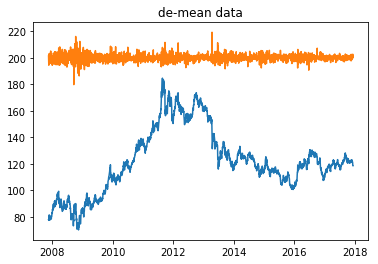

In [4]:
# Hyper parameters

# How much period taken into calculation and prediction
m = 20
# number of days prediction
RV = 22
# kbar
kbar = 8

xls_data = pd.read_excel('data_GVZ_GLD.xlsx')
date_GLD = xls_data.iloc[:,3]
GLD = xls_data.loc[:,'GLD']

GLD2 = GLD.shift(1)
GLD2[0] = GLD[0]
GLD_r = GLD/GLD2

GLD_d = GLD_r - np.mean(GLD_r)
plt.plot(date_GLD,GLD)
plt.title('de-mean data')
plt.plot(date_GLD,200*GLD_r)

data = GLD_d[::-1]


startingvals = []#[1.2, 1.2, 0.5 , 1.2 ]
LB = [1, 1, 0.001, 0.0001]
UB = [1.99, 50, 0.99999, 5]
op_methods = 'slsqp'



plt.show()

In [8]:
def tsplot(y, lags=None, figsize=(10, 8), style='bmh'):
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        #mpl.rcParams['font.family'] = 'Ubuntu Mono'
        layout = (3, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        qq_ax = plt.subplot2grid(layout, (2, 0))
        pp_ax = plt.subplot2grid(layout, (2, 1))
        
        y.plot(ax=ts_ax)
        ts_ax.set_title('Time Series Analysis Plots')
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.5)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.5)
        sm.qqplot(y, line='s', ax=qq_ax)
        qq_ax.set_title('QQ Plot')        
        scs.probplot(y, sparams=(y.mean(), y.std()), plot=pp_ax)

        plt.tight_layout()
    return 

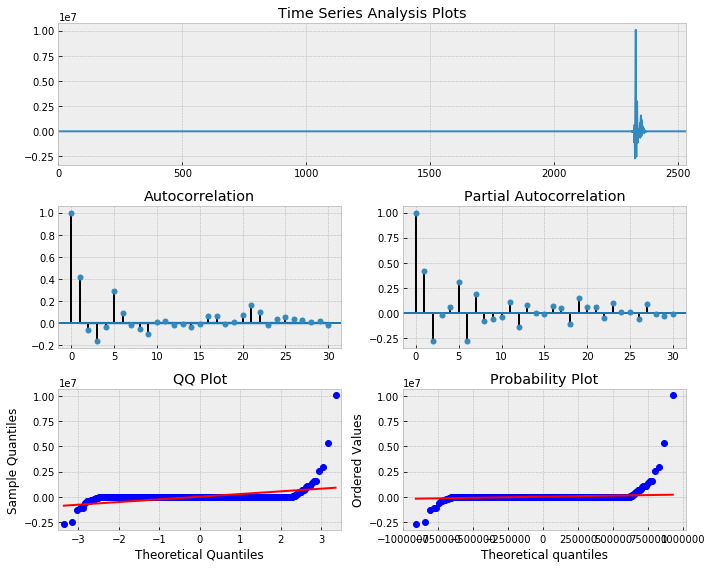

In [9]:

a0 = 0.2
a1 = 0.5
b1 = 0.3

w = GLD_d/np.std(GLD_d)
eps = np.zeros_like(w)
sigsq = np.zeros_like(w)

for i in range(1, len(GLD_d)):
    sigsq[i] = a0 + a1*(eps[i-1]**2) + b1*sigsq[i-1]
    eps[i] = w[i] * np.sqrt(sigsq[i])

_ = tsplot(eps, lags=30)

In [11]:
# Fit a GARCH(1, 1) model to our simulated EPS series
# We use the arch_model function from the ARCH package

am = arch_model(eps)
res = am.fit(update_freq=5)
print(res.summary())


Iteration:      5,   Func. Count:     36,   Neg. LLF: 29372.085432191612
Iteration:     10,   Func. Count:     66,   Neg. LLF: 29371.168179001994
Iteration:     15,   Func. Count:     96,   Neg. LLF: 29370.566960593627
Iteration:     20,   Func. Count:    126,   Neg. LLF: 29275.553194469183
Iteration:     25,   Func. Count:    157,   Neg. LLF: 29224.749740955926
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 29224.717697841676
            Iterations: 28
            Function evaluations: 186
            Gradient evaluations: 28
                     Constant Mean - GARCH Model Results                      
Dep. Variable:                      y   R-squared:                      -0.001
Mean Model:             Constant Mean   Adj. R-squared:                 -0.001
Vol Model:                      GARCH   Log-Likelihood:               -29224.7
Distribution:                  Normal   AIC:                           58457.4
Method:            Maximum L